In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from wordcloud import WordCloud

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D

In [6]:
fake_df = pd.read_csv('/content/gdrive/MyDrive/Fake.csv')
real_df = pd.read_csv('/content/gdrive/MyDrive/True.csv')

In [7]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
fake_df["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

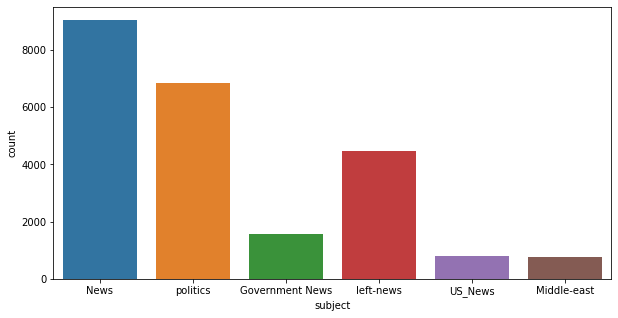

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x="subject",data = fake_df)

In [11]:
real_df["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [12]:
fake_text = ' '.join(fake_df['text'].tolist())

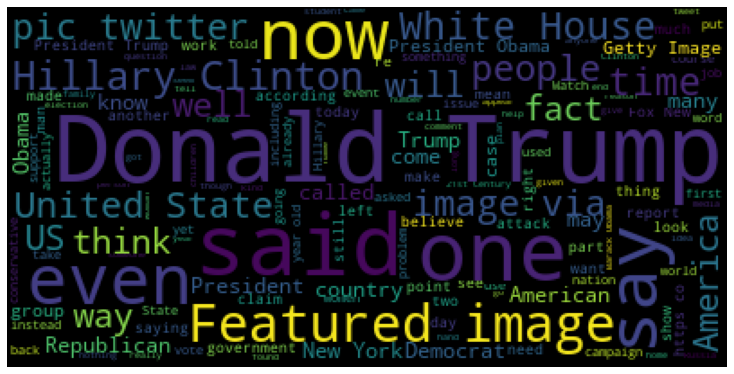

In [13]:
wordcloud_fake = WordCloud().generate(fake_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.tight_layout(pad=0)

In [14]:
real_text = ' '.join(real_df['text'].tolist())

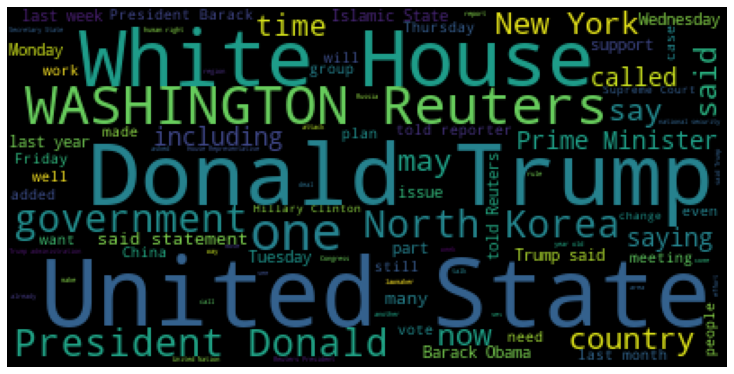

In [15]:
wordcloud_real = WordCloud().generate(real_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_real)
plt.axis('off')
plt.tight_layout(pad=0)

In [17]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [39]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [42]:
unknown_publishers =[]
for index,row in enumerate(real_df.text.values):
  try:
    record = row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [43]:
len(unknown_publishers)

221

In [44]:
real_df.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [40]:
real_df = real_df.drop(8970,axis = 0)

In [45]:
publisher = []
temp_text = []

for index,row in enumerate(real_df.text.values):
  if index in unknown_publishers:
    temp_text.append(row)
    publisher.append("Unknown")
  else:
    record = row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())

In [46]:
real_df["publisher"] = publisher
real_df['text'] = temp_text

In [47]:
real_df.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [49]:
real_df['text'] = real_df['title']+ ' ' + real_df['text']
fake_df['text'] = fake_df['title']+ ' ' + fake_df['text']

In [51]:
real_df['text'] = real_df['text'].apply(lambda x: str(x).lower())
fake_df['text'] = fake_df['text'].apply(lambda x: str(x).lower())

# Preprocessing text data

In [53]:
real_df['class'] = 1
fake_df['class'] = 0

In [54]:
real = real_df[['text','class']]

In [55]:
real.head()

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1


In [56]:
fake = fake_df[['text','class']]

In [57]:
fake.head()

,text,class
0,donald trump sends out embarrassing new year’...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obama’s name...,0
4,pope francis just called out donald trump dur...,0


In [58]:
final_data = real.append(fake,ignore_index=True)

In [59]:
final_data.sample(5)

,text,class
22267,george takei takes trump jr. to the woodshed ...,0
21531,"maine voters tell trump to go f*ck himself, e...",0
10936,trump says new hampshire win not necessary to ...,1
26819,gop official was just ‘emotional’ when he sai...,0
37039,update: former speaker hastert indicted by fed...,0


In [61]:
def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

In [62]:
final_data['text'] = final_data['text'].apply(lambda x: remove_special_chars(x))

In [63]:
final_data.head(10)

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1
5,white house congress prepare for talks on spen...,1
6,trump says russia probe will be fair but timel...,1
7,factbox trump on twitter dec 29 approval ratin...,1
8,trump on twitter dec 28 global warming the fol...,1
9,alabama official to certify senatorelect jones...,1


In [65]:
final_data.shape

(44897, 2)

In [67]:
final_data["class"].value_counts()

0    23481
1    21416
Name: class, dtype: int64

In [69]:
import nltk
from nltk.corpus import stopwords

In [70]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python'''
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [71]:
def clean_text(text, remove_stopwords):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [76]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [77]:
Clean_texts = []
for texts in final_data.text:
  Clean_texts.append(clean_text(str(texts), remove_stopwords=True))

In [78]:
final_data['clean'] = Clean_texts

In [80]:
final_data['text'] = Clean_texts

In [82]:
final_data = final_data[['text','class']]

In [83]:
final_data.head(10)

,text,class
0,us budget fight looms republicans flip fiscal ...,1
1,us military accept transgender recruits monday...,1
2,senior us republican senator let mr mueller jo...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump wants postal service charge much amazon ...,1
5,white house congress prepare talks spending im...,1
6,trump says russia probe fair timeline unclear ...,1
7,factbox trump twitter dec 29 approval rating a...,1
8,trump twitter dec 28 global warming following ...,1
9,alabama official certify senatorelect jones to...,1


In [84]:
from google.colab import files

final_data.to_csv("fakenews_df.csv", encoding='utf-8', index=False)
files.download('fakenews_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>